# Temperature Pipeline
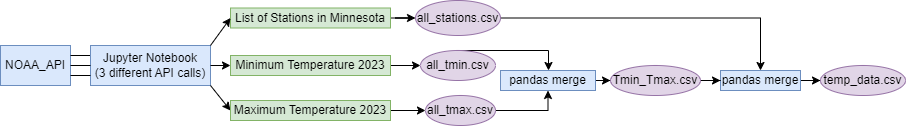

###### Credits:ChatGPT and Draw.io

## Import Statments

In [16]:
#Fixing error in arcgis notebooks, wrong locale wouldn't let us import pandas
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

#Fixing error in arcgis notebooks, wrong locale wouldn't let us import pandas
import locale
locale.setlocale(locale.LC_ALL, '')

import arcpy
import csv
import requests
from collections import deque
import time
import pandas as pd
from datetime import timedelta

## API Call and Data Preperation

In [17]:
#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)


#opens text file and reads API key
with open('./API_Keys/NOAA_Token.txt', 'r') as file:
    #.strip() takes away white space for text file errors
    api_key = file.read().strip()

#URL for API
url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/'

#password for API
headers = {
    'token': api_key
}

#function that does requests.get for API, given input paramters
#combining url with APIP parameters (information we want from API)
def api_call(url, endpoint, headers, parameters):
    url += endpoint
    response = requests.get(url, headers=headers, params=parameters)

    #check success of request
    if response.status_code == 200:
        data = response.json()
        print("API Called")
    else:
        print("Error:", response.status_code)
        data = response.status_code
    return data

#saves a list of dictionaries to a CSV file. 
    #parameters (inputs): 
        #Data: List[Dict]. A list of dictionaries containg the data can be saved (add more later--easily)
        #file name: str. The name of the file to save data to
def save_to_csv(data, filename):
    #open the file in write mode
    with open(filename, mode='w', newline='') as file:
        #set up the CSV file to write the data for all returned data (each column of csv)
            #fieldnames is the names of the columns we want to save
        #telling the CSV file we are going to give it dictionary information to paste into
        writer = csv.DictWriter(file, fieldnames=data[0].keys())
        #write the header
        writer.writeheader()
        #write the data rows
        for row in data:
            writer.writerow(row)
    print(f'Data successfully written to {filename}')

## Downloading All Minnesota Station Information

In [18]:
#endpoint tells the API where to download data from
endpoint = "/stations/"
#paramters is the data to be downloaded by the endpoint
    #locationid: state of Minnesota (FIPS:27)
    #limit: how many results that can be downloaded at one time (NOAA only allows 1000 as a maximum)
    #offset: how far into the data to go (starts at very beginning)
parameters = {
    "locationid": "FIPS:27",
    "limit": 1000,
    "offset": 1
}

#store results
all_results = []

#download data until it is 100% downloaded
while True:
    #make API call with given parameters
    data = api_call(url, endpoint, headers, parameters)
    #check if the API returned data to endpoint (did we get data back?)
        #data is a dictionary (json)
    if data is not None and 'results' in data:
        #append data to the all_results list [old_stuff, data, etc]
        #each dictionary is one station or observation
        all_results.extend(data['results'])
        
        #for the API call, check if there is more results that can be downloaded
            #'metadata' 'resultset' 'count' shows how many total results there are (i.e 2686 stations)
                #'metadata' -- information about the API call (repeats back to us, what did we ask to download?)
                #'resultset' -- information about what data they gave us (how many results are total, what resultst they are giving to us, how many is it giving us)
                #'count' -- how many total results are in what we asked in the API call (can be more than we can download in one call)
        #if the API did not download all results, we need to re-call the API to download more data
            #change offset to download the next set of results (i.e results 1000-2000)
            #check: offset + limit - 1 < total count
                #Ex. offset = 1, limit = 1000, total count = 2868
                #when we made the API call earlier, it downloaded data from 1 to 1000
                #so, we have data up to 1000 (offset + limit = 1001; subtract 1 to get 1000)
                #we compare, is 1000 < 2686? 
                    #yes, so we update offset to download the next 1000 observations
                    #offset += limit (offset = 1001)
            #this is all inside a loop, so it goes back to the start and downloads data for the next 1000 observations
                #continues to repeat until all data is downloaded
        if parameters['offset'] + parameters['limit'] - 1 < data['metadata']['resultset']['count']:
            parameters['offset'] += parameters['limit']
        else:
            break
    else:
        #handle error or no data case
        print("No data returned or an error occurred")
        break
all_results

API Called
API Called
API Called


[{'elevation': 276.5, 'mindate': '1916-08-01', 'maxdate': '2015-11-01', 'latitude': 47.2991, 'name': 'ADA, MN US', 'datacoverage': 0.9497, 'id': 'COOP:210018', 'elevationUnit': 'METERS', 'longitude': -96.5161}, {'elevation': 348.1, 'mindate': '1961-08-01', 'maxdate': '2015-11-01', 'latitude': 48.3005, 'name': 'AGASSIZ REFUGE, MN US', 'datacoverage': 0.9295, 'id': 'COOP:210050', 'elevationUnit': 'METERS', 'longitude': -95.9816}, {'elevation': 370.3, 'mindate': '1948-08-01', 'maxdate': '2015-11-01', 'latitude': 46.5257, 'name': 'AITKIN 2 E, MN US', 'datacoverage': 0.8973, 'id': 'COOP:210059', 'elevationUnit': 'METERS', 'longitude': -93.6674}, {'elevation': 374.9, 'mindate': '1931-01-01', 'maxdate': '2015-11-01', 'latitude': 43.6064, 'name': 'ALBERT LEA 3 SE, MN US', 'datacoverage': 0.9922, 'id': 'COOP:210075', 'elevationUnit': 'METERS', 'longitude': -93.3019}, {'elevation': 374.9, 'mindate': '1948-08-01', 'maxdate': '2003-09-01', 'latitude': 43.66667, 'name': 'ALBERT LEA 3 E, MN US', 'da

## Save Data to a CSV File

In [19]:
#save data to CSV
save_to_csv(all_results, 'all_stations.csv')

Data successfully written to all_stations.csv


## Downloading Maximum Temperature Data

In [20]:
#endpoint tells the API where to download data from
endpoint = '/data/'

#specify parameters (inputs)
    #datasetid -- what type of data (GHCND is climate data)
    #locationid -- Location of data (FIPS:27 is Minnesota)
    #datatypeid -- What data (TMAX is maximum temperature)
    #units -- standard/metric (metric celcius)
    #startdate -- where to start download (Jan 1 2023)
    #enddate -- where to end download (Dec 31 2023)
parameters = {
    'datasetid': 'GHCND',
    'locationid': 'FIPS:27',
    'datatypeid': 'TMAX',
    'limit': 1000, #max is 1000 for a single request
    'offset': 1,
    'units': 'metric',
    'startdate': '2023-01-01',
    'enddate': '2023-12-31'
}

all_results = []  #list to store all results
max_retries = 30  #maximum number of retries for a API call
retry_delay = 5  #delay between retries in seconds


#basically does same thing as last while loop
#but has error detection so it does not break if the API call fails
while True:
    #tries to make API call, (code is exact same as station wile loop)
    try:
        #make API call with given parameters
        data = api_call(url, endpoint, headers, parameters)
        #check if the API returned data to endpoint (did we get data back?)
        if data is not None and 'results' in data:
            #append data to the all_results list [old_stuff, data, etc]
            all_results.extend(data['results'])
            
            #for the API call, check if there is more results that can be downloaded
            if parameters['offset'] + parameters['limit'] - 1 < data['metadata']['resultset']['count']:
                parameters['offset'] += parameters['limit']
            else:
                break  #exit loop if no more results
        else:
            #handle case where data is returned but no results key is found
            print("No results found in data")
            break

    #if the API fails, it is going to print error and try again
    except Exception as e:
        print(f"An error occurred: {e}")
        max_retries -= 1 
        if max_retries <= 0:
            print("Maximum retries reached, exiting.")
            break  #exit loop after reaching max retries
        else:
            print("Retrying...")
            #wait before retrying
            time.sleep(retry_delay)  
            #note: The offset is not updated here, so the loop retries the same API call

API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
Error: 503
An error occurred: argument of type 'int' is not iterable
Retrying...
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called


## Saves Maximum Data into a CSV FILE

In [21]:
save_to_csv(all_results, 'all_TMAX.csv')

Data successfully written to all_TMAX.csv


## Download Minimum Temperature Data

In [22]:
#endpoint tells the API where to download data from
endpoint = '/data/'

#specify parameters (inputs)
    #datasetid -- what type of data (GHCND is climate data)
    #locationid -- Location of data (FIPS:27 is Minnesota)
    #datatypeid -- What data (TMAX is maximum temperature)
    #units -- standard/metric (metric celcius)
    #startdate -- where to start download (Jan 1 2023)
    #enddate -- where to end download (Dec 31 2023)
parameters = {
    'datasetid': 'GHCND',
    'locationid': 'FIPS:27',
    'datatypeid': 'TMIN',
    'limit': 1000, #max is 1000 for a single request
    'offset': 1,
    'units': 'metric',
    'startdate': '2023-01-01',
    'enddate': '2023-12-31'
}

all_results = []  # List to store all results
max_retries = 30  # Maximum number of retries for a single API call
retry_delay = 5  # Delay between retries in seconds

#exact same as loop for maximum temperature
#basically does same thing as last while loop
#but has error detection so it does not break if the API call fails
while True:
    #tries to make API call, (code is exact same as station wile loop)
    try:
        #make API call with given parameters
        data = api_call(url, endpoint, headers, parameters)
        #check if the API returned data to endpoint (did we get data back?)
        if data is not None and 'results' in data:
            #append data to the all_results list [old_stuff, data, etc]
            all_results.extend(data['results'])
            
            #for the API call, check if there is more results that can be downloaded
            if parameters['offset'] + parameters['limit'] - 1 < data['metadata']['resultset']['count']:
                parameters['offset'] += parameters['limit']
            else:
                break  #exit loop if no more results
        else:
            #handle case where data is returned but no results key is found
            print("No results found in data")
            break

    #if the API fails, it is going to print error and try again
    except Exception as e:
        print(f"An error occurred: {e}")
        max_retries -= 1 
        if max_retries <= 0:
            print("Maximum retries reached, exiting.")
            break  #exit loop after reaching max retries
        else:
            print("Retrying...")
            #wait before retrying
            time.sleep(retry_delay)  
            #note: The offset is not updated here, so the loop retries the same API call

API Called
API Called
API Called
API Called
API Called
API Called
API Called
Error: 503
An error occurred: argument of type 'int' is not iterable
Retrying...
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
Error: 503
An error occurred: argument of type 'int' is not iterable
Retrying...
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called
API Called


## Saves Minimum Data to CSV File

In [23]:
save_to_csv(all_results, 'all_TMIN.csv')

Data successfully written to all_TMIN.csv


## Data Cleaning

In [24]:
#data CLEANING
tmin_df = pd.read_csv('ALL_TMIN.csv')
tmax_df = pd.read_csv('ALL_TMAX.csv')

#merge TMAX and TMIN on 'date' and 'station'
merged_temp_df = pd.merge(tmax_df[['date', 'station', 'value']], tmin_df[['date', 'station', 'value']], on=['date', 'station'], suffixes=('_TMAX', '_TMIN'))

In [25]:
merged_temp_df.to_csv('TMIN_TMAX.csv')

In [26]:
#TMIN_TMAX have station ID's but no location data
#we use all_stations to find the latitude and longitude of the station TMIN_TMAX has
tmin_tmax_df = pd.read_csv('TMIN_TMAX.csv')
stations_df = pd.read_csv('all_stations.csv')

#merge the two datasets based on station and station id
merged_df_correct = pd.merge(tmin_tmax_df, stations_df, left_on='station', right_on='id', how='left')

#clean the data and only output useful numbers
merged_df = merged_df_correct[['date', 'station', 'value_TMAX', 'value_TMIN', 'latitude', 'longitude']]

## Save CSV in One File

In [27]:
merged_df.to_csv('temp_data.csv', index = False)

## Quality Assurance Quality Control Pipeline
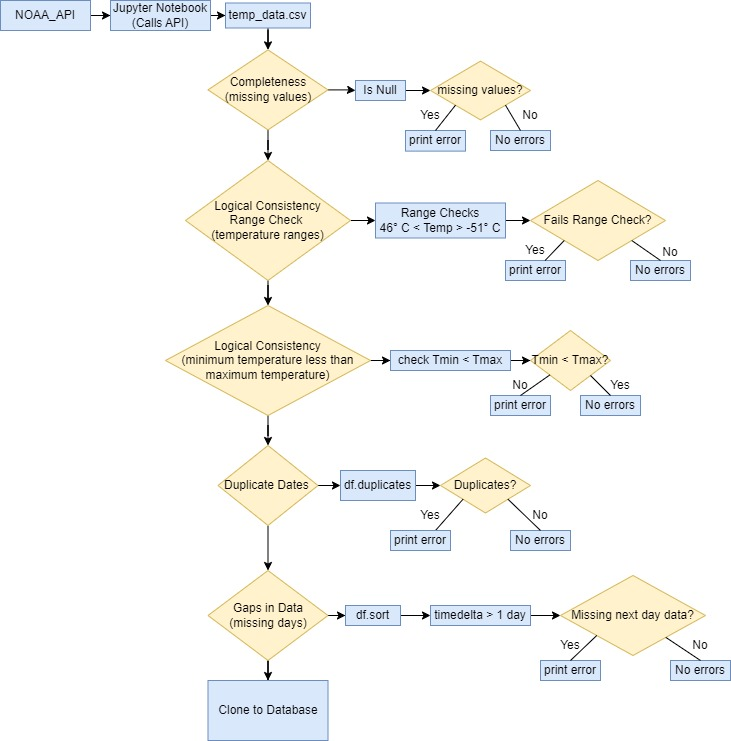

In [28]:
#load the dataset
df = pd.read_csv('temp_data.csv')

#convert date column to datetime for easier manipulation
df['date'] = pd.to_datetime(df['date'])

#1. Missing Values Check
missing_values_check = df[['value_TMAX', 'value_TMIN']].isnull().sum()
if missing_values_check['value_TMAX'] > 0:
    print('Error: Missing TMAX')
elif missing_values_check['value_TMIN'] > 0:
    print('Error: Missing TMIN')
else:
    print('No missing values')
    
#2. Logical Consistency Check (TMIN should not be greater than TMAX)
logical_inconsistency_check = df[df['value_TMIN'] > df['value_TMAX']].shape[0]
if logical_inconsistency_check > 0:
    print('Warning: There are rows where TMIN is greater than TMAX')  
    print('Data is bad')  
else:
    print('Data is good') 
    
# 3.Temperature Range Outliers Check
temperature_outliers_check = {
    'TMAX_below_typical_min': df[df['value_TMAX'] < -51].shape[0],
    'TMAX_above_typical_max': df[df['value_TMAX'] > 46].shape[0],
    'TMIN_below_typical_min': df[df['value_TMIN'] < -51].shape[0],
    'TMIN_above_typical_max': df[df['value_TMIN'] > 46].shape[0]
}
#counting total outliers
total_outliers = sum(temperature_outliers_check.values())
if total_outliers > 0:
    print('Warning: Temperature outliers detected')  # If temperature outliers found, print warning
    print('Data is bad')  # If temperature outliers found, print data is bad
else:
    print('Data is good')  # If no temperature outliers found, print data is good
    
# 4.Duplicate Dates Check
duplicate_dates_check = df.duplicated(subset=['station', 'date']).sum()

if duplicate_dates_check > 0:
    print('Warning: There are duplicate dates in the dataset')  # If duplicate dates found, print warning
    print('Data is bad')  # If duplicate dates found, print data is bad
else:
    print('Data is good')  # If no duplicate dates found, print data is good

#5. Potential Gaps in Data
df_sorted = df.sort_values(by=['station', 'date'])
df_sorted['next_date'] = df_sorted.groupby('station')['date'].shift(-1)
df_sorted['date_diff'] = df_sorted['next_date'] - df_sorted['date']
gaps_check = df_sorted[df_sorted['date_diff'] > timedelta(days=1)].shape[0]

if gaps_check > 1000:
    print('Warning: There are potential gaps in the data')  
    print('Data is bad') 
else:
    print('Data is good')
    
#print results (or further analyze, depending on your needs)
print("Missing Values Check:\n", missing_values_check)
print("\nLogical Inconsistency Check:\n", logical_inconsistency_check)
print("\nTemperature Outliers Check:\n", temperature_outliers_check)
print("\nDuplicate Dates Check:\n", duplicate_dates_check)
print("\nPotential Gaps in Data Check:\n", gaps_check)

No missing values
Data is good
Data is good
Data is good
Data is good
Missing Values Check:
 value_TMAX    0
value_TMIN    0
dtype: int64

Logical Inconsistency Check:
 0

Temperature Outliers Check:
 {'TMAX_below_typical_min': 0, 'TMAX_above_typical_max': 0, 'TMIN_below_typical_min': 0, 'TMIN_above_typical_max': 0}

Duplicate Dates Check:
 0

Potential Gaps in Data Check:
 751
